# Heat Exchanger Performance — Analysis Notebook

> Sensors: U1 (dewar bottom), U2 (coil top), U3 (dewar top), U4 (coil middle).

In [22]:
# --- Configuration ---
from pathlib import Path

# Heuristic: if running inside HFE_SYSTEM/analysis/notebooks, climb until we see /data and /analysis
NB_PATH = Path.cwd()
REPO_ROOT = NB_PATH
for up in [NB_PATH, *NB_PATH.parents]:
    if (up / "data").exists() and (up / "analysis").exists():
        REPO_ROOT = up
        break

# Input CSVs (change if needed)
RAW_DIR   = REPO_ROOT / "data" / "raw"
NOMIX_CSV = RAW_DIR / "tc_log_20251021_152400-nomix.csv"
MIXED_CSV = RAW_DIR / "tc_log_20251021_142527-mixed1sttest.csv"

# Outputs (will be created if missing)
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
REPORTS_DIR   = REPO_ROOT / "data" / "reports"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Fluid properties (adjust to your mixture)
rho_kgL      = 1.07   # density [kg/L]
cp_kJkgK     = 3.5    # specific heat [kJ/kg-K]
fill_volumeL = 5.4    # bath volume [L]

# Analysis options
ROLL_WINDOW_S   = 45.0          # smoothing window for dT/dt [s]
EARLY_TMIN0     = 1.0           # early fit window start [min]
EARLY_TMIN1     = 5.0           # early fit window end [min]
EARLY_DT_MIN    = 1.0           # min ΔT for early regression [°C]
EARLY_DT_MAX    = 12.0          # max ΔT for early regression [°C]
SUMMARY_WINDOWS = [(2,6),(6,10),(10,14)]  # reporting windows

In [15]:
# --- Imports & bath capacity ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hfe_ana import (
    apparent_power,
    apply_corrections,
    bath_capacity_j_per_k,
    fit_heat_leak_and_UA,
    integrate_energy,
    load_tc_csv,
    rolling_slope,
)

rho, cp_kJkgK, V_L = rho_kgL, cp_kJkgK, fill_volumeL
m_kg = rho * V_L
Cp_JK = bath_capacity_j_per_k(V_L, rho, cp_kJkgK)
print(f"Cp (bath): {Cp_JK:.0f} J/K")


Cp (bath): 20223 J/K


## Helpers

Utility functions are provided by the `hfe_ana` package (see previous cell).


In [16]:
# --- Load data & compute apparent bath power ---
mixed = load_tc_csv(MIXED_CSV) if MIXED_CSV.exists() else None
nomix = load_tc_csv(NOMIX_CSV)

for d in [nomix, mixed] if mixed is not None else [nomix]:
    d["dTbulk_dt_C_per_s"] = rolling_slope(d["time_s"], d["T_bulk_mean_C"], window_s=ROLL_WINDOW_S)
    d["P_bath_W"] = -Cp_JK * d["dTbulk_dt_C_per_s"]

nomix.head(3)

,time_s,temp0_C,U1_bottom_C,U2_coilTop_C,U3_top_C,U4_coilMid_C,temp5_C,temp6_C,temp7_C,temp8_C,temp9_C,valve,mode,t_min,T_bulk_mean_C,T_coil_mean_C,DeltaT_C,Strat_top_minus_bottom_C,dTbulk_dt_C_per_s,P_bath_W
0,12.053,NaN,9.74,9.66,10.45,9.98,NaN,NaN,NaN,NaN,NaN,1,O,0.200883,10.095,9.820,0.275,0.71,0.000674,-13.621385
1,13.058,NaN,9.74,9.48,10.44,9.93,NaN,NaN,NaN,NaN,NaN,1,O,0.217633,10.090,9.705,0.385,0.70,0.001049,-21.218818
2,14.063,NaN,9.70,9.30,10.43,10.02,NaN,NaN,NaN,NaN,NaN,1,O,0.234383,10.065,9.660,0.405,0.73,0.001056,-21.363639


## Temperatures & stratification

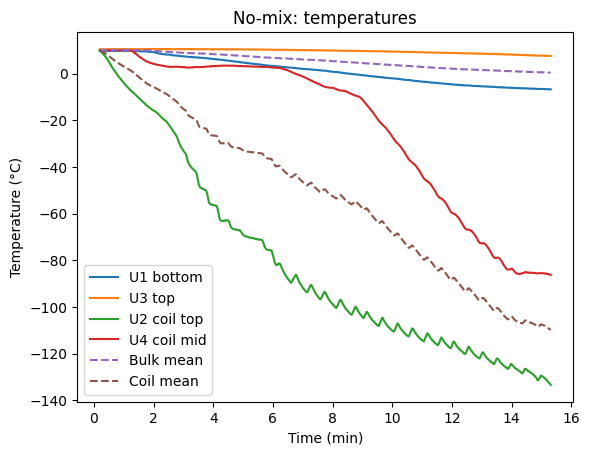

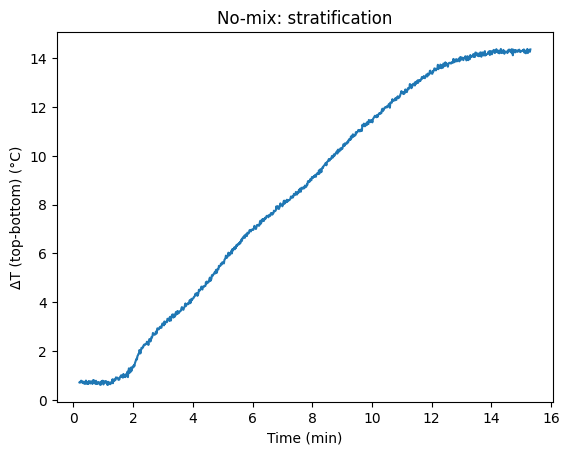

In [17]:
plt.figure()
plt.plot(nomix["t_min"], nomix["U1_bottom_C"], label="U1 bottom")
plt.plot(nomix["t_min"], nomix["U3_top_C"],   label="U3 top")
plt.plot(nomix["t_min"], nomix["U2_coilTop_C"], label="U2 coil top")
plt.plot(nomix["t_min"], nomix["U4_coilMid_C"], label="U4 coil mid")
plt.plot(nomix["t_min"], nomix["T_bulk_mean_C"], linestyle="--", label="Bulk mean")
plt.plot(nomix["t_min"], nomix["T_coil_mean_C"], linestyle="--", label="Coil mean")
plt.xlabel("Time (min)"); plt.ylabel("Temperature (°C)"); plt.title("No-mix: temperatures"); plt.legend(); plt.show()

plt.figure()
plt.plot(nomix["t_min"], nomix["Strat_top_minus_bottom_C"])
plt.xlabel("Time (min)"); plt.ylabel("ΔT (top-bottom) (°C)"); plt.title("No-mix: stratification"); plt.show()

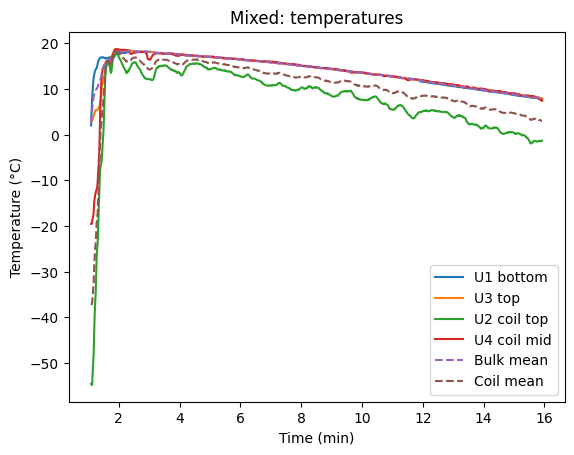

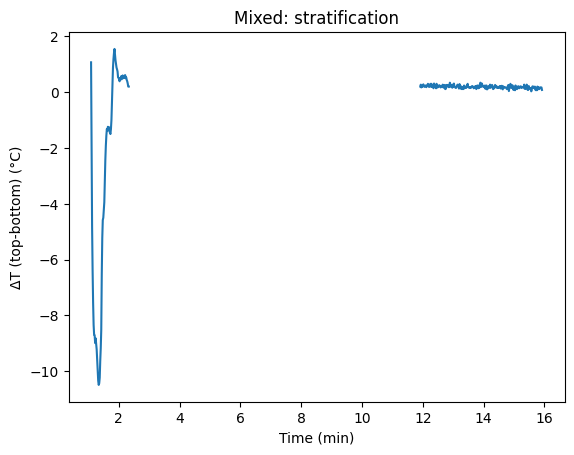

In [24]:
plt.figure()
plt.plot(mixed["t_min"], mixed["U1_bottom_C"], label="U1 bottom")
plt.plot(mixed["t_min"], mixed["U3_top_C"],   label="U3 top")
plt.plot(mixed["t_min"], mixed["U2_coilTop_C"], label="U2 coil top")
plt.plot(mixed["t_min"], mixed["U4_coilMid_C"], label="U4 coil mid")
plt.plot(mixed["t_min"], mixed["T_bulk_mean_C"], linestyle="--", label="Bulk mean")
plt.plot(mixed["t_min"], mixed["T_coil_mean_C"], linestyle="--", label="Coil mean")
plt.xlabel("Time (min)"); plt.ylabel("Temperature (°C)"); plt.title("Mixed: temperatures"); plt.legend(); plt.show()

plt.figure()
plt.plot(mixed["t_min"], mixed["Strat_top_minus_bottom_C"])
plt.xlabel("Time (min)"); plt.ylabel("ΔT (top-bottom) (°C)"); plt.title("Mixed: stratification"); plt.show()

## Estimate ambient heat leak **H** and early **UA**

Early UA = 21.85 W/K, Heat leak H = 144 W, R²=0.976, points=33


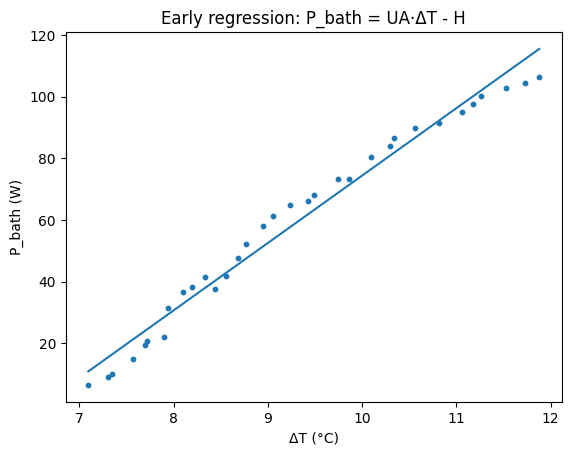

In [23]:
result = fit_heat_leak_and_UA(
    nomix,
    tmin_window=(EARLY_TMIN0, EARLY_TMIN1),
    deltaT_range=(EARLY_DT_MIN, EARLY_DT_MAX),
)
print(
    f"Early UA = {result.UA_W_per_K:.2f} W/K, Heat leak H = {result.heat_leak_W:.0f} W, "
    f"R²={result.r_squared:.3f}, points={result.n_points}"
)

early = nomix[
    (nomix["t_min"] > EARLY_TMIN0)
    & (nomix["t_min"] < EARLY_TMIN1)
    & (~nomix["P_bath_W"].isna())
    & (nomix["DeltaT_C"] > EARLY_DT_MIN)
    & (nomix["DeltaT_C"] < EARLY_DT_MAX)
]
plt.figure()
plt.scatter(early["DeltaT_C"], early["P_bath_W"], s=10)
x = np.linspace(early["DeltaT_C"].min(), early["DeltaT_C"].max(), 200)
plt.plot(x, result.UA_W_per_K * x - result.heat_leak_W)
plt.xlabel("ΔT (°C)")
plt.ylabel("P_bath (W)")
plt.title("Early regression: P_bath = UA·ΔT - H")
plt.show()


## Corrected HX power & UA vs time

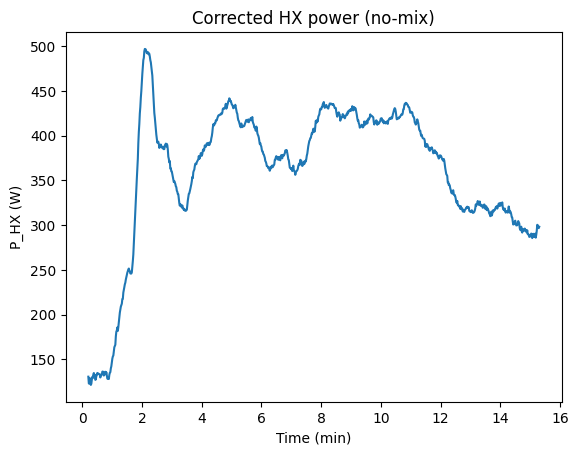

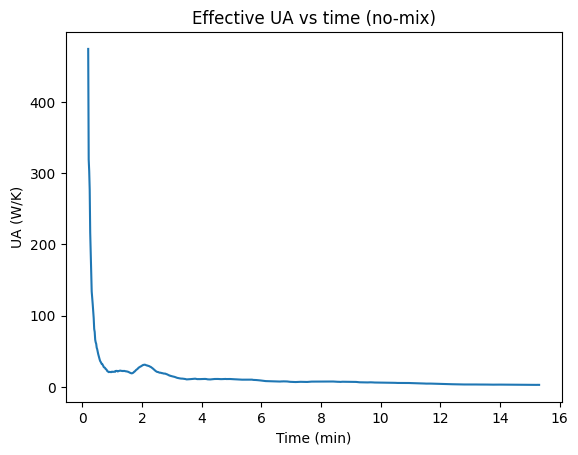

In [40]:
nomix = apply_corrections(nomix, result.heat_leak_W)

plt.figure(); plt.plot(nomix["t_min"], nomix["P_HX_W"])
plt.xlabel("Time (min)")
plt.ylabel("P_HX (W)")
plt.title("Corrected HX power (no-mix)")
plt.show()

plt.figure(); plt.plot(nomix["t_min"], nomix["UA_corr_W_per_K"])
plt.xlabel("Time (min)")
plt.ylabel("UA (W/K)")
plt.title("Effective UA vs time (no-mix)")
plt.show()


## Windowed medians (power & UA)

In [41]:
def summarize_window(df, t0, t1):
    s = df[(df["t_min"]>=t0)&(df["t_min"]<=t1)&(~df["P_HX_W"].isna())&(df["DeltaT_C"]>0.5)]
    if len(s)==0:
        return {"window": f"{t0}–{t1}","P_med_W":np.nan,"P_10_W":np.nan,"P_90_W":np.nan,
                "UA_med_WK":np.nan,"UA_10_WK":np.nan,"UA_90_WK":np.nan,"N":0}
    Pmed = float(np.nanmedian(s["P_HX_W"])); P10,P90 = np.nanpercentile(s["P_HX_W"],[10,90])
    UAmed = float(np.nanmedian(s["UA_corr_W_per_K"])); UA10,UA90 = np.nanpercentile(s["UA_corr_W_per_K"].dropna(),[10,90])
    return {"window":f"{t0}–{t1}","P_med_W":round(Pmed,1),"P_10_W":round(P10,1),"P_90_W":round(P90,1),
            "UA_med_WK":round(UAmed,2),"UA_10_WK":round(UA10,2),"UA_90_WK":round(UA90,2),"N":len(s)}

summary_df = pd.DataFrame([summarize_window(nomix, *w) for w in SUMMARY_WINDOWS])
summary_df

,window,P_med_W,P_10_W,P_90_W,UA_med_WK,UA_10_WK,UA_90_WK,N
0,2–6,401.2,337.0,441.1,10.94,10.01,23.90,239
1,6–10,412.6,365.3,431.9,7.03,6.17,7.65,239
2,10–14,376.2,316.4,425.6,4.17,3.10,5.60,238


## Net energy removed by the HX (ambient-corrected)

In [42]:
sel = (nomix["t_min"] >= 2) & (nomix["t_min"] <= 14) & (~nomix["P_HX_W"].isna())
E_HX_kJ = integrate_energy(nomix.loc[sel, "time_s"], nomix.loc[sel, "P_HX_W"]) / 1000.0
print(f"Integrated HX energy 2–14 min: {E_HX_kJ:.0f} kJ")


Integrated HX energy 2–14 min: 280 kJ


## Export results

In [44]:
timeseries_out = PROCESSED_DIR / "hx_timeseries_corrected.csv"
summary_out    = REPORTS_DIR   / "hx_summary_windows.csv"
params_out     = REPORTS_DIR   / "hx_fit_params.txt"

ts = nomix[[
    "time_s",
    "t_min",
    "T_bulk_mean_C",
    "T_coil_mean_C",
    "DeltaT_C",
    "P_bath_W",
    "P_HX_W",
    "UA_corr_W_per_K",
]]
ts.to_csv(timeseries_out, index=False)
summary_df.to_csv(summary_out, index=False)
with open(params_out, "w") as f:
    f.write(f"UA_early_WK: {result.UA_W_per_K:.3f}")
    f.write(f"H_W: {result.heat_leak_W:.1f}")
    f.write(f"R2: {result.r_squared:.3f}")
    f.write(f"N_regression: {result.n_points}")
    f.write(f"Cp_JK: {Cp_JK:.1f}")
    f.write(f"Volume_L: {V_L}")
print("Saved:", timeseries_out)
print("Saved:", summary_out)
print("Saved:", params_out)


Saved: /home/pocar-lab/Documents/HFE_System/data/processed/hx_timeseries_corrected.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_summary_windows.csv
Saved: /home/pocar-lab/Documents/HFE_System/data/reports/hx_fit_params.txt
